# Exploratory Data Analysis

Team: Bralska

Members: 
- Filip Sawicki
- Felipe Antonini Miehring
- Alexandre Muchinski

Dataset: Sales data provided by GMM Trgovina, a private company in construction tools wholesale business operating in balkan region.

## 1. Importing the data

To import and preprocess the data we have implemented "Loader" class which is available in our private github repository.

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from operator import attrgetter
from dateutil.relativedelta import relativedelta
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

import plotly.express as px
from plotly.offline import iplot

from modules.loader import Loader

In [2]:
loader = Loader()
df_cust = loader.load_customers()
df_inv = loader.load_inventory()
df_sal = loader.load_sales_data()
df_sal = loader.add_channels(df_sal, df_cust)
df_sal = loader.add_nls(df_sal, df_inv)

C:\Users\fpsaw\Desktop\42578-Advanced-Business-Analytics\modules\loader.py:113: FutureWarning:

The default value of regex will change from True to False in a future version.



## 2. General overview of datasets

### 2.1. Shape of data

In [3]:
print('Inventory Shape:', df_inv.shape)
df_inv.head()

Inventory Shape: (19968, 8)


sku                                   descr    brand  quantity  \
0  00001           NASTAVEK ZA MEŠANJE A F1=60MM  PROLINE        10   
1  00002   NASTAVEK ZA MEŠANJE MASE 80x400 TIP A  PROLINE        18   
2  00003   NASTAVEK ZA MEŠANJE MASE 100X500 TIPA  PROLINE        10   
3  00004   NASTAVEK ZA MEŠANJE MASE 80x400 TIP B  PROLINE        14   
4  00005  NASTAVEK ZA MEŠANJE MASE 100X500 TIP B  PROLINE         0   

   last_cost  unit_price category    NLS  
0       0.73        2.28      NaN  False  
1       1.49        4.86      NaN  False  
2       2.10        6.15      NaN  False  
3       1.67        4.86      NaN  False  
4       1.48        6.00      NaN  False

In [4]:
print('Customers Shape:', df_cust.shape)
df_cust.head()

Customers Shape: (12543, 11)


id                              name payer_id  \
0  00001             Prva dimenzija d.o.o.    00001   
1  00002           DOBROTIĆ-MONTAŽA D.O.O.    00002   
2  00003            Masivna Pasivna d.o.o.    00003   
3  00005  ZIDARSKA DELA ZVONKO ŠEBALJ S.P.    00005   
4  00006                   MARCHIOL d.o.o.    00006   

                         payer_name                 city post_code  \
0             Prva dimenzija d.o.o.              medvode      1215   
1           DOBROTIĆ-MONTAŽA D.O.O.               ivanec  HR-42245   
2            Masivna Pasivna d.o.o.                trzin      1236   
3  ZIDARSKA DELA ZVONKO ŠEBALJ S.P.  leskovec pri krškem      8273   
4                   MARCHIOL d.o.o.          nova gorica      5000   

  country_region_code  is_b2c  latitude  longitude  population  
0                  SI   False  46.13049   14.40272     15542.0  
1                  HR    True  46.22306   16.12000      5461.0  
2                  SI   False  46.12527   14.55256      3844.0  
3                  SI   False  45.93566   15.47184      1021.0  
4                  SI    True  45.95604   13.64837     13178.0

In [5]:
print('Sales Shape:', df_sal.shape)
df_sal.head()

Sales Shape: (406324, 12)


sku cust_id payer_id   invoice_no      ddate  quantity  cost  price  \
0     20298  080001   080001  PRA19-00001 2019-07-10         1 -3.31   7.88   
1    X50137  080001   080001  PRA19-00002 2019-07-10         1 -3.09   6.18   
2    X51108  080001   080001  PRA19-00002 2019-07-10         1 -1.72   3.64   
3     10713  080001   080001  PRA19-00006 2019-07-10         1 -2.66   6.33   
4  1-30-497  901105   901105  PRA19-00007 2019-07-10         2 -5.42   7.26   

  sales_person  is_return channel    NLS  
0         SHOP      False    SHOP  False  
1         SHOP      False    SHOP  False  
2         SHOP      False    SHOP   True  
3         SHOP      False    SHOP  False  
4         SHOP      False    SHOP  False

### 2.2. Missing values analysis

In general dataset is clean and has just a few missing values. Most notable is sales_person in sales data and category in inventory data, which is assigned manually.

In [6]:
def describe_missing(df):
    no_rows = len(df)
    missing_no = df.isna().sum()
    missing_pr = np.around((missing_no / no_rows) * 100, 2)
    df = pd.DataFrame([missing_no, missing_pr], index=['Missing #', 'Missing %'])
    display(df)

In [7]:
print('Missing values: Customers')
describe_missing(df_cust)

Missing values: Customers


id  name  payer_id  payer_name    city  post_code  \
Missing #  0.0  4.00       0.0        4.00  375.00     210.00   
Missing %  0.0  0.03       0.0        0.03    2.99       1.67   

           country_region_code  is_b2c  latitude  longitude  population  
Missing #               191.00     0.0    529.00     529.00      529.00  
Missing %                 1.52     0.0      4.22       4.22        4.22

In [8]:
print('Missing values: Inventory')
describe_missing(df_inv)

Missing values: Inventory


sku  descr  brand  quantity  last_cost  unit_price  category  NLS
Missing #  0.0    0.0    0.0       0.0        0.0         0.0  19311.00  0.0
Missing %  0.0    0.0    0.0       0.0        0.0         0.0     96.71  0.0

In [9]:
print('Missing values: Sales Data')
describe_missing(df_sal)

Missing values: Sales Data


sku  cust_id  payer_id  invoice_no  ddate  quantity  cost  price  \
Missing #  0.0     11.0      11.0         0.0    0.0       0.0   0.0    0.0   
Missing %  0.0      0.0       0.0         0.0    0.0       0.0   0.0    0.0   

           sales_person  is_return  channel  NLS  
Missing #      22678.00        0.0      0.0  0.0  
Missing %          5.58        0.0      0.0  0.0

### 2.3. Simple plots of summary statistics

In [10]:
df_sal.describe(include='all', percentiles = [])

<ipython-input-10-5a081269b077>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



sku cust_id payer_id   invoice_no                ddate  \
count   406324  406313   406313       406324               406324   
unique   15518    5755     4857       106422                 1293   
top        E07  080001   906760  PDO19+04573  2019-09-30 00:00:00   
freq      7509   36284    45964          596                 1441   
first      NaN     NaN      NaN          NaN  2018-01-04 00:00:00   
last       NaN     NaN      NaN          NaN  2022-03-23 00:00:00   
mean       NaN     NaN      NaN          NaN                  NaN   
std        NaN     NaN      NaN          NaN                  NaN   
min        NaN     NaN      NaN          NaN                  NaN   
50%        NaN     NaN      NaN          NaN                  NaN   
max        NaN     NaN      NaN          NaN                  NaN   

             quantity           cost          price sales_person is_return  \
count   406324.000000  406324.000000  406324.000000       383646    406324   
unique            NaN            NaN            NaN           39         2   
top               NaN            NaN            NaN         SHOP     False   
freq              NaN            NaN            NaN        75384    387625   
first             NaN            NaN            NaN          NaN       NaN   
last              NaN            NaN            NaN          NaN       NaN   
mean         4.017543     -49.267737      67.096643          NaN       NaN   
std         21.444953     313.885103     496.481962          NaN       NaN   
min      -1520.000000  -44696.610000  -65209.900000          NaN       NaN   
50%          2.000000     -10.820000      16.730000          NaN       NaN   
max       6000.000000   31300.010000  132514.490000          NaN       NaN   

       channel     NLS  
count   406324  406324  
unique       3       2  
top        B2B   False  
freq    326746  327127  
first      NaN     NaN  
last       NaN     NaN  
mean       NaN     NaN  
std        NaN     NaN  
min        NaN     NaN  
50%        NaN     NaN  
max        NaN     NaN

In [11]:
df_inv.describe(include = 'all', percentiles = [])

sku           descr    brand      quantity     last_cost  \
count   19968           19968    19968  19968.000000  19968.000000   
unique  19968           18674       68           NaN           NaN   
top     10176  VALJ Z DRŽALOM  PROLINE           NaN           NaN   
freq        1              21     5213           NaN           NaN   
mean      NaN             NaN      NaN     12.014874     23.523872   
std       NaN             NaN      NaN    165.997038     81.466619   
min       NaN             NaN      NaN      0.000000      0.000000   
50%       NaN             NaN      NaN      0.000000      3.140000   
max       NaN             NaN      NaN  21600.000000   2324.140000   

          unit_price          category    NLS  
count   19968.000000               657  19968  
unique           NaN                74      2  
top              NaN  Acu Drill Driver  False  
freq             NaN                57  16951  
mean       61.784953               NaN    NaN  
std       199.018633               NaN    NaN  
min         0.000000               NaN    NaN  
50%        12.600000               NaN    NaN  
max     10085.690000               NaN    NaN

In [12]:
df_cust.describe(include='all', percentiles = [])

id        name payer_id             payer_name       city  \
count   12543       12539    12543                  12539      12168   
unique  12543       12153    11111                  10872        683   
top     10176  PEVEC D.D.   906760  G-M&M, ZAGREB, D.O.O.  ljubljana   
freq        1          21      320                    320       2522   
mean      NaN         NaN      NaN                    NaN        NaN   
std       NaN         NaN      NaN                    NaN        NaN   
min       NaN         NaN      NaN                    NaN        NaN   
50%       NaN         NaN      NaN                    NaN        NaN   
max       NaN         NaN      NaN                    NaN        NaN   

       post_code country_region_code is_b2c      latitude     longitude  \
count      12333               12352  12543  12014.000000  12014.000000   
unique       783                   3      2           NaN           NaN   
top         1000                  SI  False           NaN           NaN   
freq        2044               11465  11930           NaN           NaN   
mean         NaN                 NaN    NaN     46.019056     14.857966   
std          NaN                 NaN    NaN      0.401637      0.742906   
min          NaN                 NaN    NaN     42.623060     13.498760   
50%          NaN                 NaN    NaN     46.051080     14.622770   
max          NaN                 NaN    NaN     46.745280     20.444680   

           population  
count    12014.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean     78433.409273  
std     124457.827658  
min          0.000000  
50%      15207.000000  
max     698966.000000

## 3. Customer Analysis

In [13]:
df_inv.category = df_inv.category.apply(lambda x: 'Other' if x != x else x)
df_sal_inv = df_sal.merge(df_inv[['sku', 'unit_price', 'category']], right_on = 'sku', left_on = 'sku', how = 'inner')

### 3.1. Distribution of customer and channel sales

In [38]:
plt.rcParams['figure.figsize'] = [20, 5]

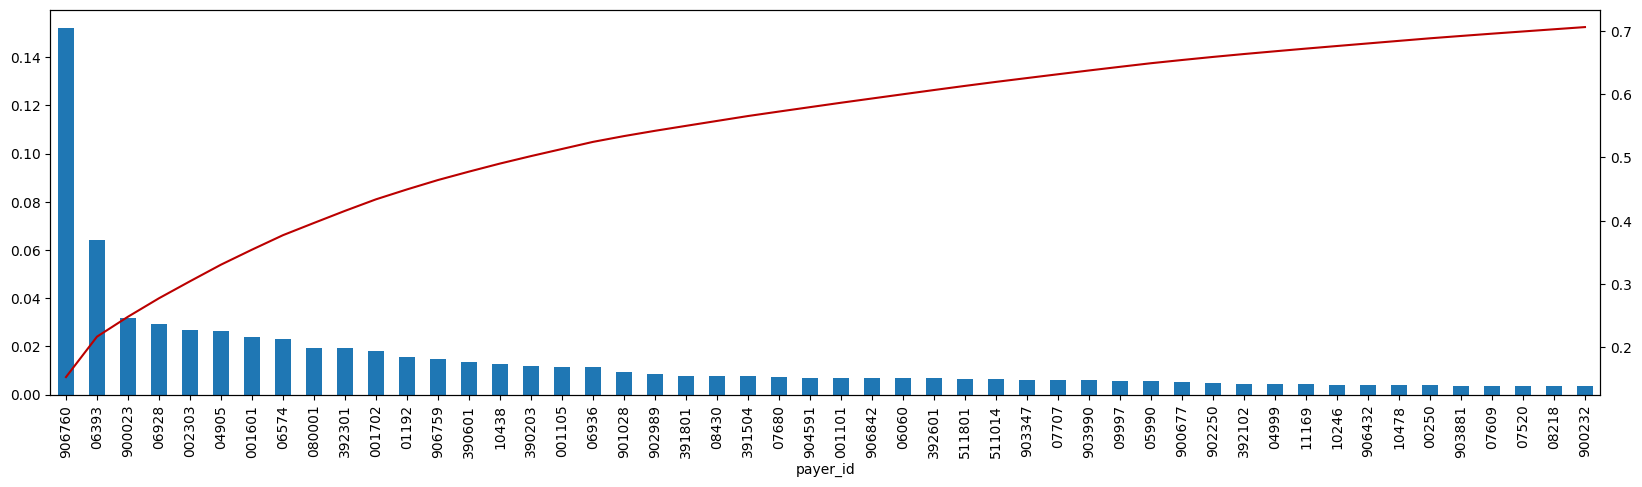

In [43]:
df_cust_dist = df_sal_inv[(df_sal_inv.NLS == False) & (df_sal_inv.price > 0)][['payer_id', 'price']] \
    .groupby('payer_id').sum('price').sort_values(by = 'price', ascending = False)
df_cust_dist['sales_percentage'] = df_cust_dist.price/df_cust_dist.price.sum()
df_cust_dist['sales_perc_acum'] = df_cust_dist['sales_percentage'].rolling(len(df_cust_dist),min_periods = 1).sum()
ax = df_cust_dist['sales_percentage'][:50].plot(kind='bar')
ax2 = ax.twinx()
df_cust_dist['sales_perc_acum'][:50].plot(kind='line', ax = ax2, grid = False, color = ['#BB0000'])
plt.show()

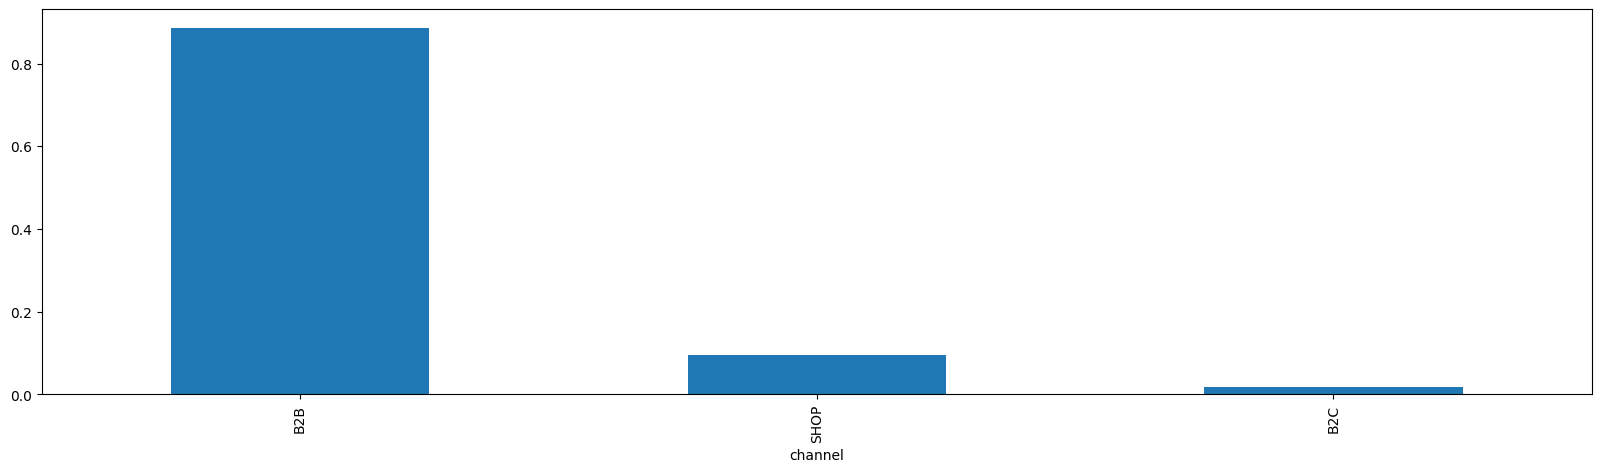

In [40]:
df_cust_dist = df_sal_inv[(df_sal_inv.NLS == False) & (df_sal_inv.price > 0)][['channel', 'price']] \
    .groupby('channel').sum('price').sort_values(by = 'price', ascending = False)
df_cust_dist['sales_percentage'] = df_cust_dist.price / df_cust_dist.price.sum()
df_cust_dist['sales_perc_acum'] = df_cust_dist['sales_percentage'].rolling(len(df_cust_dist),min_periods = 1).sum()
ax = df_cust_dist['sales_percentage'][:50].plot(kind='bar')
plt.show()

### 3.2. Cohort analysis

In [16]:
sales = df_sal[['cust_id', 'invoice_no', 'ddate']].drop_duplicates()

sales['order_month'] = sales['ddate'].dt.to_period('Q')
sales['cohort'] = sales.groupby('cust_id')['ddate'].transform('min').dt.to_period('Q')

df_cohort = sales.groupby(['cohort', 'order_month' ]).agg(n_customers = ('cust_id', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
cohort_pivot = df_cohort.pivot_table(index ='cohort', columns = 'period_number', values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

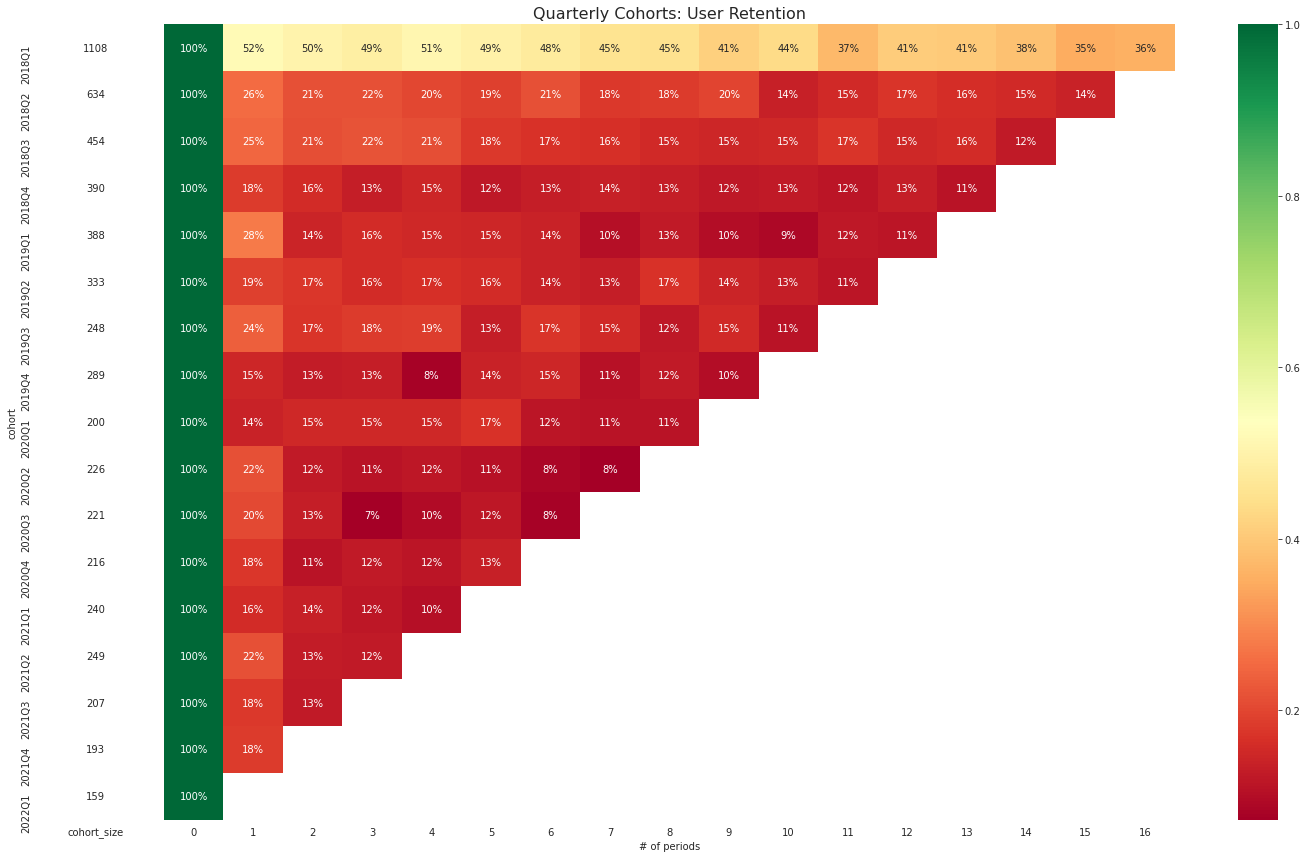

In [17]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Quarterly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

By the cohort analysis matrix we can visualize customer retention. Every row represents the number of new costumer in that one specific quarter and the columns show the percentage of those customers that remained as clients in the upcoming quarters.

As axample we can se that on 2018Q4 the company had 390 new customers. Among those, only 18% kept purchasing items on the next quarter, and after that only 16%, and so on. At the present moment, only 11% of the new customers of 2018Q4 remain as clients of the company. 

### 3.3. RFM clustering

RFM model in particular is at the core of customer segmentation. RFM studies customers’ behaviour and cluster them by using three metrics:

**Recency (R):** measure the number of days since the last purchase to a hypothetical snapshot day. (Time since last order or last engaged with the product)

**Frequency (F):** measure the number of transaction made during the period of study (total number of transaction during timeframe)

**Monetary Value (M):** Measure how much money each customer has spent during the period of study. (Total number of valuable transactions)


In [18]:
df_sal['profit'] = df_sal['price'] + df_sal['cost']
df_sales = df_sal  # copy

chunk_list = []
for chunk in df_sales:
    condition_to_drop = df_sales[df_sales['price']<=0]
    df_sales.drop(condition_to_drop.index, inplace = True)
    df_sales = df_sales.sort_values(by=['ddate'])
    #df_sales.set_index('ddate', inplace = True)
    chunk_list.append(df_sales)
    
df_sales = pd.concat(chunk_list)

df_sales['invoice_date'] = df_sales['ddate']
df_sales = df_sales.set_index('invoice_date')
df_sales['invoice_date'] = df_sales.index

end_date = df_sales.index.max()
start_date = end_date - relativedelta(years = 4)
snapshot_date = end_date + relativedelta(days=1)

study_df = df_sales
data_rfm = study_df.groupby(['cust_id']).agg({
    'invoice_date' : lambda x : (snapshot_date - x.max()).days,
    'invoice_no':'nunique',
    'price':'sum'
})


data_rfm.rename(columns ={
    'invoice_date':'Recency',
    'invoice_no':'Frequency',
    'price':'MonetaryValue'
}, inplace = True)
data_rfm_log = np.log(data_rfm)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_rfm_log)

#store it separately for clustering
data_rfm_standard = scaler.transform(data_rfm_log)

#turn the processed data back into a dataframe
data_rfm_standard = pd.DataFrame(data = data_rfm_standard, 
                                index = data_rfm.index, 
                                columns = data_rfm.columns) 

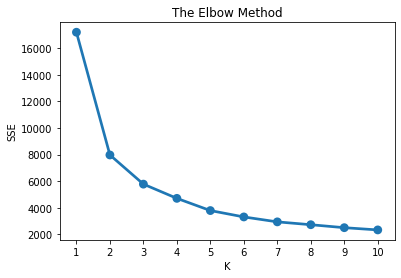

In [20]:
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

#fit KMeans and calculate SSE for each K
sse = {}
for k in range(1,11):
	kmeans = KMeans(n_clusters = k, random_state=1)
	kmeans.fit(data_rfm_standard)
	sse[k] = kmeans.inertia_ 

#plot SSE for each K
plt.title('The Elbow Method')
plt.xlabel('K'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 4, random_state=1)
#compute k-means clustering on pre-processed data
kmeans.fit(data_rfm_standard)
#extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_ 

In [22]:
df_k3 = data_rfm.assign(Cluster = cluster_labels) 

In [23]:
summary = df_k3.groupby(['Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
    })
print(summary) 

            Recency   Frequency  MonetaryValue      
               mean        mean           mean count
Cluster                                             
0         88.015094    2.855346    4812.368616   795
1         33.553082  134.541096  551446.744452   584
2        863.433913    1.388980    1721.103854  3049
3        433.755743   10.131700   40158.334441  1306


In [24]:
df_k3_outlier = df_k3
df_k3_outlier['cust_id'] = df_k3.index
df_k3_outlier= df_k3_outlier[df_k3_outlier.cust_id != '080001']

In [25]:
fig = px.scatter_3d(df_k3_outlier, x='Recency', y='Frequency', z='MonetaryValue',
                    hover_data=[df_k3_outlier.index],
                    title='RFM Clustering of Clients',
                   color='Cluster')
iplot(fig) 

Based on the 3 dimensions of the clustering procedure we identify the cluster 1 as the one containing the most “valuable” customers. As these have a high average purchase values, have a high mean frequency and a small Recency (have on average purchased something recently). We can also observe that cluster 2 contains the most negligible customers, with a low average purchase value and very low frequency (probably one timers). The other clusters represent customers in-between.

## 4. Sales Data Analysis

### 4.1. Distribution of product and category sales

In [32]:
df_sal

sku cust_id payer_id   invoice_no      ddate  quantity   cost  \
0          20298  080001   080001  PRA19-00001 2019-07-10         1  -3.31   
1         X50137  080001   080001  PRA19-00002 2019-07-10         1  -3.09   
2         X51108  080001   080001  PRA19-00002 2019-07-10         1  -1.72   
3          10713  080001   080001  PRA19-00006 2019-07-10         1  -2.66   
4       1-30-497  901105   901105  PRA19-00007 2019-07-10         2  -5.42   
...          ...     ...      ...          ...        ...       ...    ...   
406319    DT2061  900059   900059  PDO22+05287 2022-03-23         1  -2.22   
406320   DT20707  900059   900059  PDO22+05287 2022-03-23         1  -5.85   
406321   DT20704  900059   900059  PDO22+05287 2022-03-23         1  -4.94   
406322    DT2344  900059   900059  PDO22+05287 2022-03-23         1  -6.44   
406323    DT2402  900059   900059  PDO22+05287 2022-03-23         1 -13.43   

        price sales_person  is_return channel    NLS  
0        7.88         SHOP      False    SHOP  False  
1        6.18         SHOP      False    SHOP  False  
2        3.64         SHOP      False    SHOP   True  
3        6.33         SHOP      False    SHOP  False  
4        7.26         SHOP      False    SHOP  False  
...       ...          ...        ...     ...    ...  
406319   6.23         SHOP      False    SHOP  False  
406320  19.31         SHOP      False    SHOP  False  
406321  10.77         SHOP      False    SHOP  False  
406322  14.27         SHOP      False    SHOP  False  
406323  31.67         SHOP      False    SHOP  False  

[406324 rows x 12 columns]

In [39]:
df_sal

sku cust_id payer_id   invoice_no      ddate  quantity   cost  \
0          20298  080001   080001  PRA19-00001 2019-07-10         1  -3.31   
1         X50137  080001   080001  PRA19-00002 2019-07-10         1  -3.09   
2         X51108  080001   080001  PRA19-00002 2019-07-10         1  -1.72   
3          10713  080001   080001  PRA19-00006 2019-07-10         1  -2.66   
4       1-30-497  901105   901105  PRA19-00007 2019-07-10         2  -5.42   
...          ...     ...      ...          ...        ...       ...    ...   
406319    DT2061  900059   900059  PDO22+05287 2022-03-23         1  -2.22   
406320   DT20707  900059   900059  PDO22+05287 2022-03-23         1  -5.85   
406321   DT20704  900059   900059  PDO22+05287 2022-03-23         1  -4.94   
406322    DT2344  900059   900059  PDO22+05287 2022-03-23         1  -6.44   
406323    DT2402  900059   900059  PDO22+05287 2022-03-23         1 -13.43   

        price sales_person  is_return channel    NLS  
0        7.88         SHOP      False    SHOP  False  
1        6.18         SHOP      False    SHOP  False  
2        3.64         SHOP      False    SHOP   True  
3        6.33         SHOP      False    SHOP  False  
4        7.26         SHOP      False    SHOP  False  
...       ...          ...        ...     ...    ...  
406319   6.23         SHOP      False    SHOP  False  
406320  19.31         SHOP      False    SHOP  False  
406321  10.77         SHOP      False    SHOP  False  
406322  14.27         SHOP      False    SHOP  False  
406323  31.67         SHOP      False    SHOP  False  

[406324 rows x 12 columns]

In [42]:
df_sal[['sku', 'cust_id', 'quantity']].groupby(['sku', 'cust_id']).sum().reset_index()

sku cust_id  quantity
0       0-03-105   07588         1
1       0-03-105  906761         2
2       0-03-105  906842        14
3       0-10-018  001101        51
4       0-10-018   00314        20
...          ...     ...       ...
156447       ZZM  906848         1
156448       ZZM  906855         1
156449       ZZM  906979         2
156450       ZZM  907084         1
156451       ZZM  907091         1

[156452 rows x 3 columns]

In [46]:
df_sal[['sku', 'cust_id', 'quantity']].groupby(['sku', 'cust_id']).sum().reset_index().max()['quantity']

15400

In [4]:
df_sal_inv = df_sal.merge(df_inv[['sku', 'unit_price', 'category']], right_on = 'sku', left_on = 'sku', how = 'inner')

In [14]:
df_sales_dist = df_sal_inv[(df_sal_inv.NLS == False) & (df_sal_inv.price > 0)][['sku', 'price', 'quantity']]\
    .groupby('sku').sum(['price', 'quantity']).sort_values(by = 'price',ascending = False)

In [21]:
df_sales_dist['sales_percentage'] = df_sales_dist.price / df_sales_dist.price.sum()

In [26]:
df2 = df_sales_dist.sort_values(by='sales_percentage', ascending = False).cumsum()

In [37]:
list(df2.loc[df2['sales_percentage'] < 0.9].index)

['DCD796P2',
 'DWE4237',
 'BEG110',
 'DCD795D2',
 'BDCHD18BAFC',
 'DWE4257',
 'DCH133M1',
 'DCG405P2',
 'DCE089D1G',
 'BDCDC18BAFC',
 'D25133K',
 'ASHLEY 110',
 'FME190',
 'D25481K',
 'DCG405NT',
 'KW712',
 'DWE397',
 'DCD791P2',
 'DCF620D2',
 'JOKER1400S',
 'DT2976',
 'KS501',
 'D25144KP',
 'NVB12AV',
 'DCD710D2',
 'DWE398',
 'DCD778D2T',
 'DWE6423',
 'D25614K',
 'DCB184',
 'DWE492',
 'D25899K',
 'DCN692P2',
 'DCD777S2T',
 'D25134K',
 'DWE4157',
 'DW733',
 'DWP849X',
 'CS1250L',
 'DT3507',
 'DCF880M2',
 'DCD796D2',
 '90368',
 'DCM561P1',
 '1-30-697',
 'DCG412M2',
 'DWS780',
 'BCG720M1',
 'DCG405N',
 'KX1650',
 'DCK211D2T',
 'DWE560',
 'STC1840EPC',
 'DCF899P2',
 'DCH254M2',
 'KA88',
 'DCK2080P2T',
 'DCF887P2',
 'DCD710C2',
 'KA900E',
 'DCK383P2T',
 'DWE305PK',
 'DCD796NT',
 'DCD778D2T + DT7274',
 'DCD771C2',
 'FMC625D2',
 'DCK266P2',
 '34319',
 'DCH133NT',
 'DWE492DUO2',
 'DCD708D2T',
 'BEG220',
 'DWE4057',
 'DW088K',
 'DW088KN',
 'KA280K',
 'CS1550',
 'D25333K',
 'DWV902L',
 '0-30-69

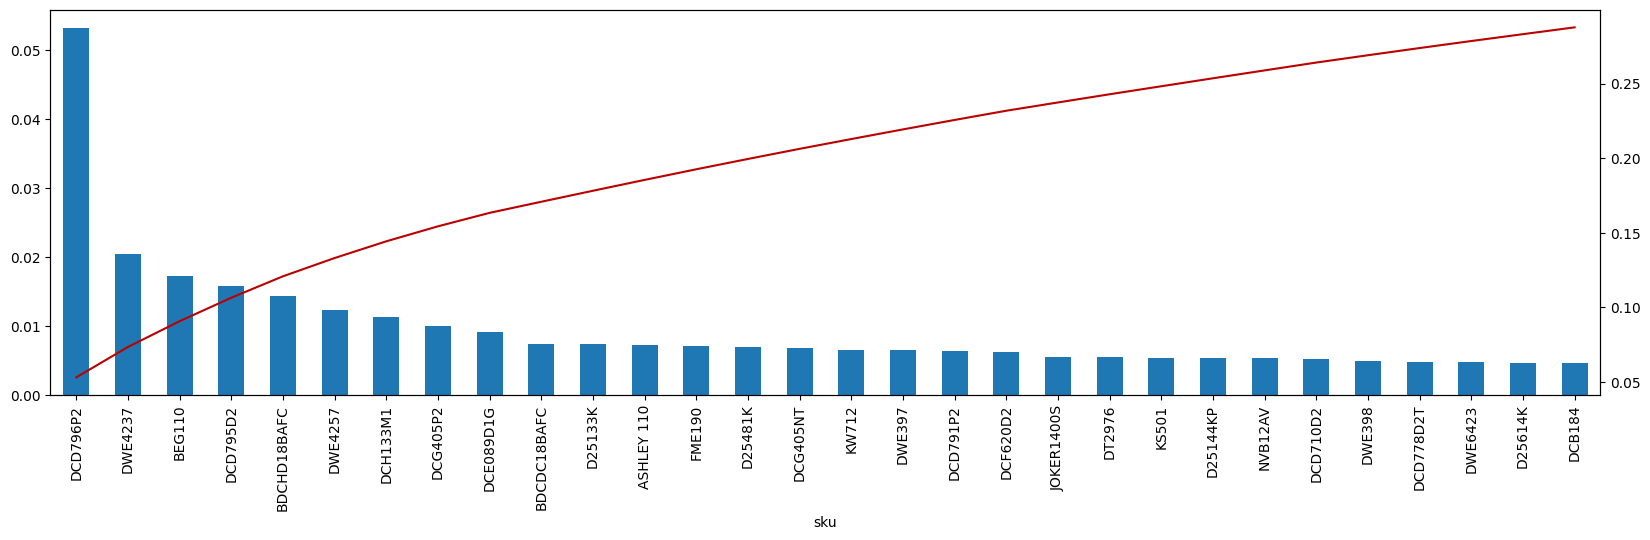

In [41]:
df_sales_dist = df_sal_inv[(df_sal_inv.NLS == False) & (df_sal_inv.price > 0)][['sku', 'price']]\
    .groupby('sku').sum('price').sort_values(by = 'price',ascending = False)
df_sales_dist['sales_percentage'] = df_sales_dist.price/df_sales_dist.price.sum()
df_sales_dist['sales_perc_acum'] = df_sales_dist['sales_percentage'].rolling(len(df_sales_dist),min_periods = 1).sum()
ax = df_sales_dist['sales_percentage'][:30].plot(kind='bar') 
ax2 = ax.twinx()
df_sales_dist['sales_perc_acum'][:30].plot(kind='line', ax = ax2, grid = False, color = ['#BB0000'])
plt.show()

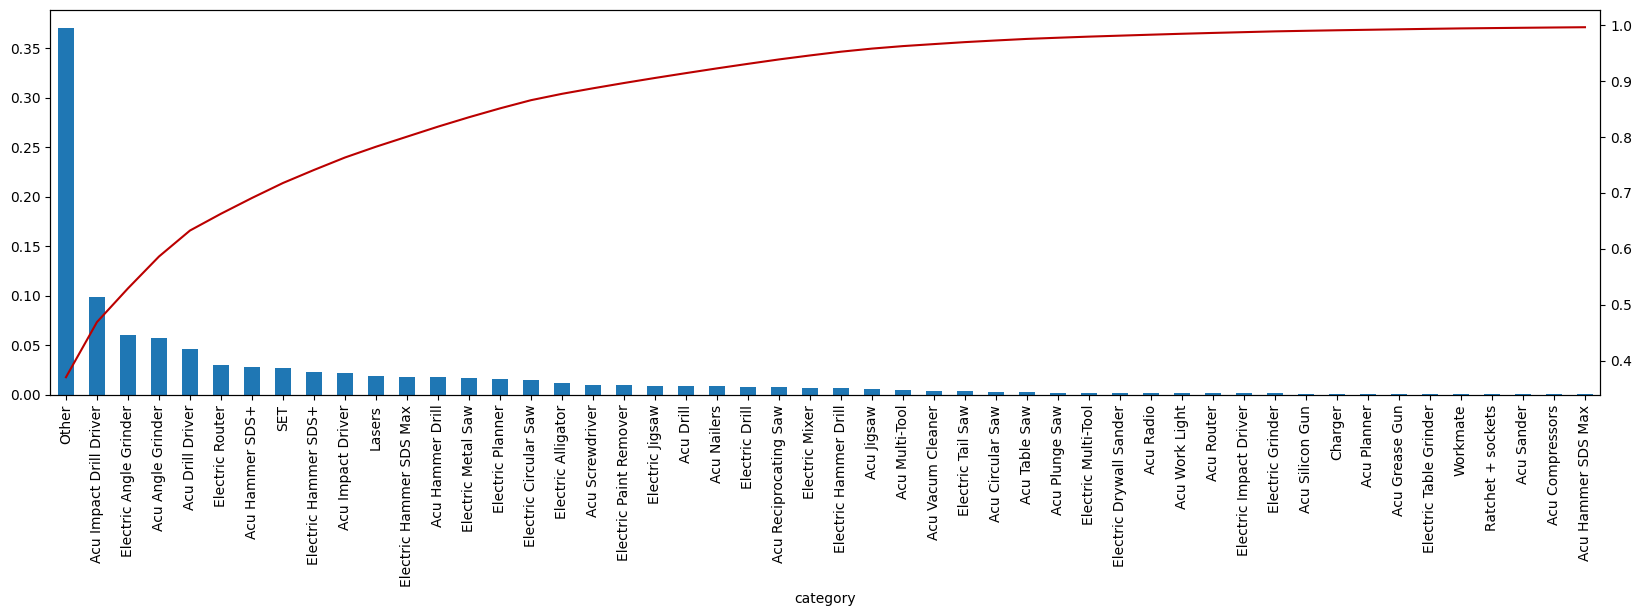

In [42]:
df_cat_dist = df_sal_inv[(df_sal_inv.NLS == False) & (df_sal_inv.price > 0)][['category', 'price']] \
    .groupby('category').sum('price').sort_values(by = 'price',ascending = False)
df_cat_dist['sales_percentage'] = df_cat_dist.price/df_cat_dist.price.sum()
df_cat_dist['sales_perc_acum'] = df_cat_dist['sales_percentage'].rolling(len(df_cat_dist),min_periods = 1).sum()
ax = df_cat_dist['sales_percentage'][:50].plot(kind='bar')
ax2 = ax.twinx()
df_cat_dist['sales_perc_acum'][:50].plot(kind='line', ax = ax2, grid = False, color = ['#BB0000'])
plt.show()

### 4.2. Sales by month

In general sales have significant variability which seems to be increasing every year along with the volume.

In [28]:
import matplotlib as mpl

def plot_sales_data(df):
    mpl.style.use('default')
    # Aggregate sales to month-year
    df = df_sal.set_index('ddate')
    df = df.resample('MS').sum()

    # Define plot
    plt.rcParams['figure.figsize'] = [20, 5]
    fig, ax = plt.subplots()
    ax.plot(df.index, df['price'], label="sales")
    
    # Change x_axis to show month and year with correct (centered) intervals
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%B'))
    fmt_month = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(fmt_month)
    ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    # Show sales values for each month-year
    for i,j in zip(df.index, df.price):
        ax.annotate(str(int(j)), xy=(i,j))

    # Add lines to locate consecutive years easier
    for year in ['2018', '2019', '2020', '2021', '2022']:
        ax.axvline(pd.Timestamp(f"{year}-01-01"), color='b', linestyle='--')

    # Final styling options
    plt.title(f"Montly Sales Data")
    plt.xticks(rotation=50)
    plt.grid()
    plt.legend(loc="upper left")
    plt.show()

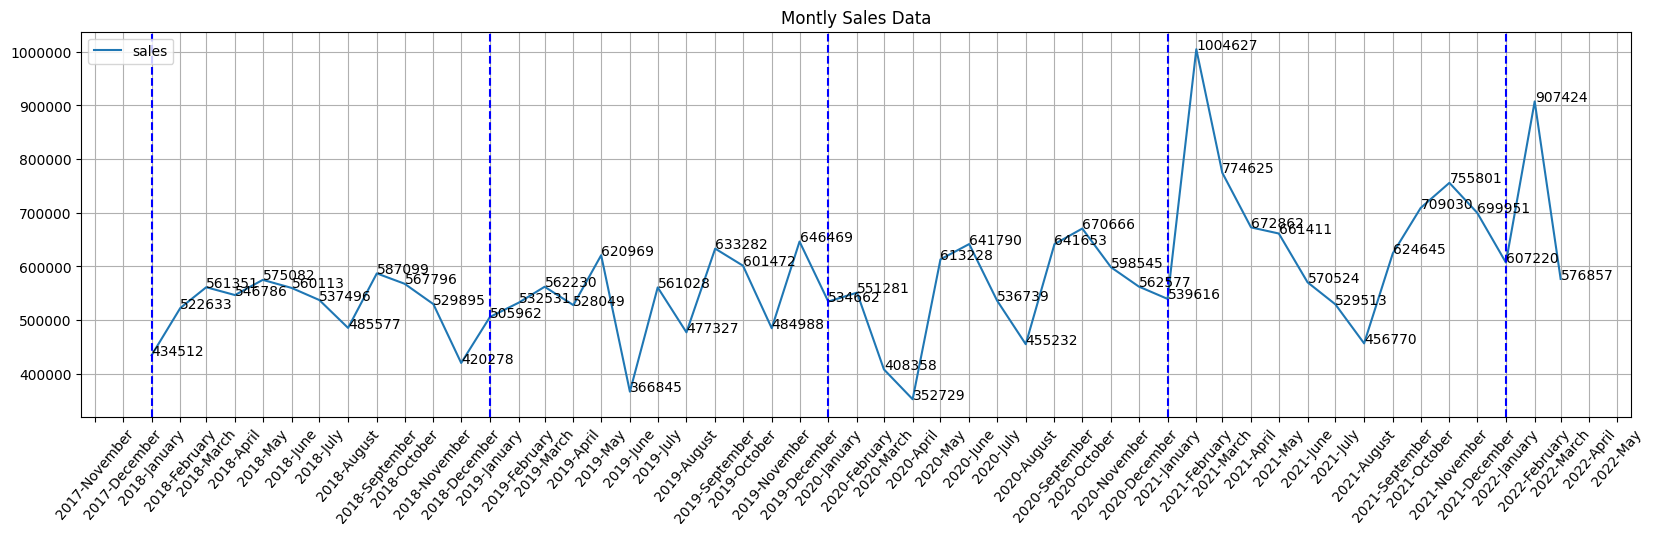

In [29]:
plot_sales_data(df_sal)

### 4.3. Sales by location

Looking at the plot we can clearly see that majority of customers and sales volume is in slovenia, followed by croatia and then bosnia. As expected magnitude of sales is influenced by the proximity to the large cities or population densities.

In [30]:
HOVERTEMPLATE = """
<b>%{customdata[3]}</b> <br>
Sales: %{customdata[2]}€ <br>
Quantity: %{customdata[1]} <br>
Population: %{customdata[4]} <br><br>
<b>TOP 20 Clients</b> <br> %{customdata[0]}
"""


def show_data(df, sal, col='Znesek_prodaje_dejanski',  bin_scale=True, period=None, sku=None, brand=None):
    if sku:
        sal = sal.loc[sal['sku'] == sku]
    if brand:
        sal = sal.loc[sal['brand'] == brand]
    if period:
        sal = sal.loc[sal['ddate'].dt.year == int(period)]
    
    sal = sal[['cust_id', 'quantity', 'price']] \
        .groupby('cust_id').sum().reset_index()

    df = df[['id', 'name', 'city', 'longitude', 'latitude', 'population']]

    custs = pd.merge(df, sal, left_on='id', right_on='cust_id') \
        .sort_values(by=['price'], ascending=False)
    custs = custs[['city', 'name']].groupby(['city'], as_index=False) \
        .agg(lambda x: '<br>'.join(map(str, x[:20])))

    df_cities = df.drop_duplicates(subset=['city'])[['city', 'longitude', 'latitude', 'population']]

    df = pd.merge(
        df, sal, left_on='id', right_on='cust_id', how='right'
    ).dropna(subset=['id'])
    
    df = df.groupby("city").sum()
    df = df.reset_index()
    df = df[['city', 'quantity', 'price']]
    df = df.loc[df['city'] != '']
    
    df = pd.merge(
        df, 
        df_cities, 
        left_on='city', right_on='city', how='right'
    ).dropna()
    
    df = pd.merge(
        df,
        custs,
        on='city', how='left'
    )
    
    all_data_diffq = (df[col].max() - df[col].min()) / 16
    df["scale"] = (df[col] - df[col].min()) / all_data_diffq + 1
    
    df[col] = df[col].fillna(0)
    df.loc[df[col] < 0] = 0
    
    z = ('scale' if bin_scale else col)

    fig = px.scatter_mapbox(df, lat='latitude', lon='longitude', color=z, size=z, hover_name="city", 
        hover_data=['quantity', 'price'],
        custom_data=['name', 'quantity', 'price', 'city', 'population'],
        center=dict(lat=45.81, lon=15.96), zoom=6,
        color_continuous_scale='bluered', height=800,
        mapbox_style="carto-positron"
    )
    fig.update_traces(hovertemplate=HOVERTEMPLATE)
    fig.show()

**Warning: This map requires JavaScript running**

In [31]:
show_data(df_cust, df_sal, col='price', bin_scale=False)

### 4.4. Sales seasonality decomposition

To understand seasonality and trend of company's sales statistically we have used STL decomposition method, which stands for “Seasonal and Trend decomposition using Loess”. It is a commonly used method that captures non-linear relationships in time series by decomposing it into a sum of three components "seasonality", "trend" and "residual".

In [32]:
def plot_decomposition(df, show):
    plt.rcParams['figure.figsize'] = [20, 5]
    
    df = df.set_index('ddate')
    df = df.resample('MS').sum()
    
    df_lookup = df # .loc[df.index > '2019-12-31']
    
    fig, ax = plt.subplots()
    if "sales" in show:
        ax.plot(df_lookup.index, df_lookup['price'], label="sales")
    if "quantity" in show:
        ax.plot(df_lookup.index, df_lookup['quantity'], label="quantity")
        for i,j in zip(df_lookup.index, df_lookup['quantity']):
            ax.annotate(str(int(j)), xy=(i,j))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%B'))
    fmt_month = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(fmt_month)
    ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    ax.axvline(pd.Timestamp("2018-01-01"), color='b', linestyle='--')
    ax.axvline(pd.Timestamp("2019-01-01"), color='b', linestyle='--')
    ax.axvline(pd.Timestamp("2020-01-01"), color='b', linestyle='--')
    ax.axvline(pd.Timestamp("2021-01-01"), color='b', linestyle='--')
    ax.axvline(pd.Timestamp("2022-01-01"), color='b', linestyle='--')

    plt.title(f"total (seasonal + trend + resid)")
    plt.xticks(rotation=50)
    plt.grid()
    plt.legend(loc="upper left")
    
    try:
        decompose_prodaje = STL(df['price'], seasonal=13, robust=True).fit()
        decompose_quant = STL(df['quantity'], seasonal=13, robust=True).fit()
    
        for decomp_type in ['seasonal', 'trend', 'resid']:
            dec_prod = getattr(decompose_prodaje, decomp_type).fillna(0)
#             dec_prod = dec_prod[dec_prod.index > '2019-12-31']
            dec_quan = getattr(decompose_quant, decomp_type).fillna(0)
#             dec_quan = dec_quan[dec_quan.index > '2019-12-31']

            fig, ax = plt.subplots()
            if "sales" in show:
                ax.plot(dec_prod.index, dec_prod, label="sales")
            if "quantity" in show:
                ax.plot(dec_quan.index, dec_quan, label="quantity")
                for i,j in zip(dec_quan.index, dec_quan):
                    ax.annotate(str(int(j)), xy=(i,j))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%B'))

            fmt_month = mdates.MonthLocator(interval=1)
            ax.xaxis.set_major_locator(fmt_month)
            ax.ticklabel_format(useOffset=False, style='plain', axis='y')
            
            ax.axvline(pd.Timestamp("2018-01-01"), color='b', linestyle='--')
            ax.axvline(pd.Timestamp("2019-01-01"), color='b', linestyle='--')
            ax.axvline(pd.Timestamp("2020-01-01"), color='b', linestyle='--')
            ax.axvline(pd.Timestamp("2021-01-01"), color='b', linestyle='--')
            ax.axvline(pd.Timestamp("2022-01-01"), color='b', linestyle='--')

            plt.title(f"{decomp_type} decomposition")

            plt.xticks(rotation=50)
            plt.grid()
            plt.legend(loc="upper left")
    except ValueError as e:
        print(e)
        print('Cannot show decomposition, must have at least 24 months of data available!')

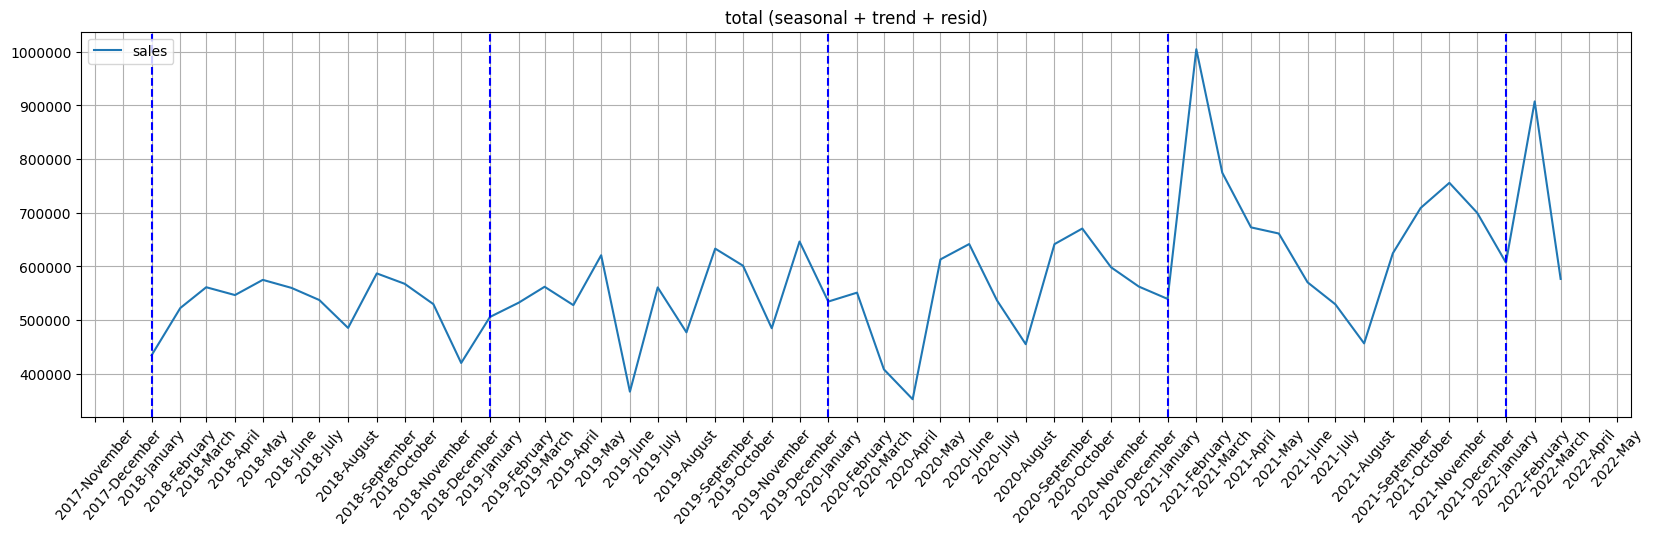

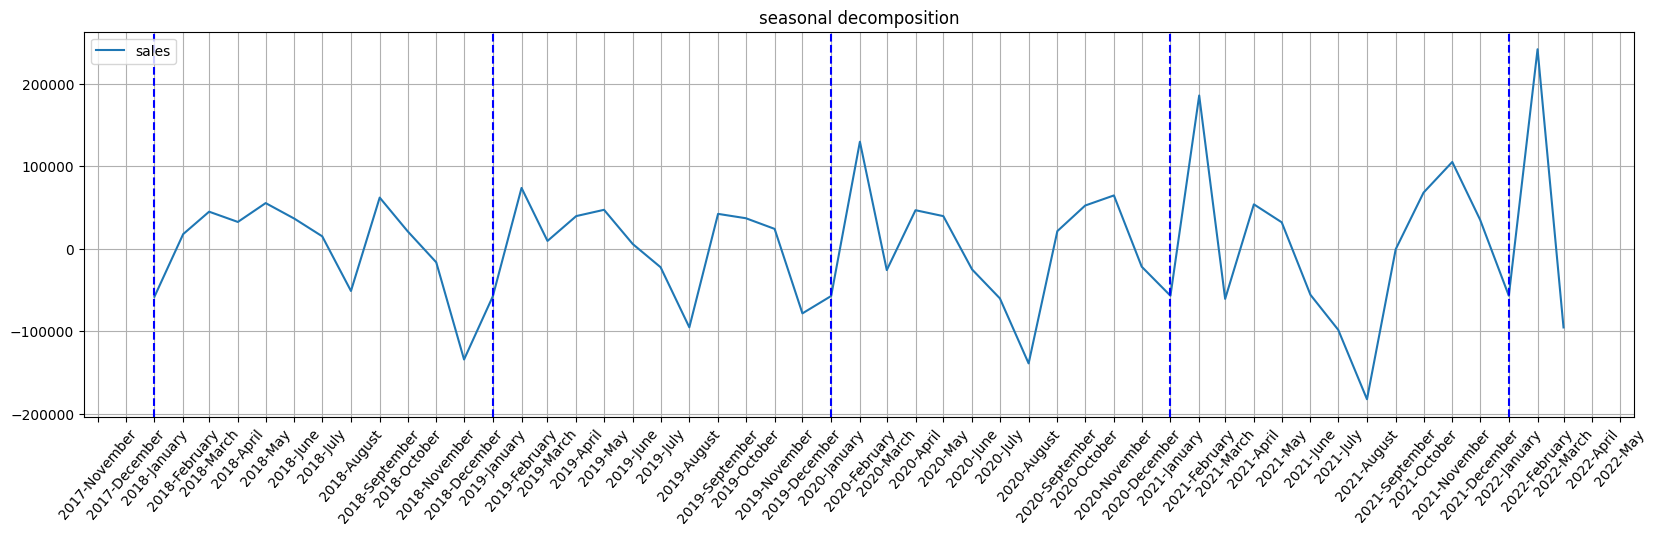

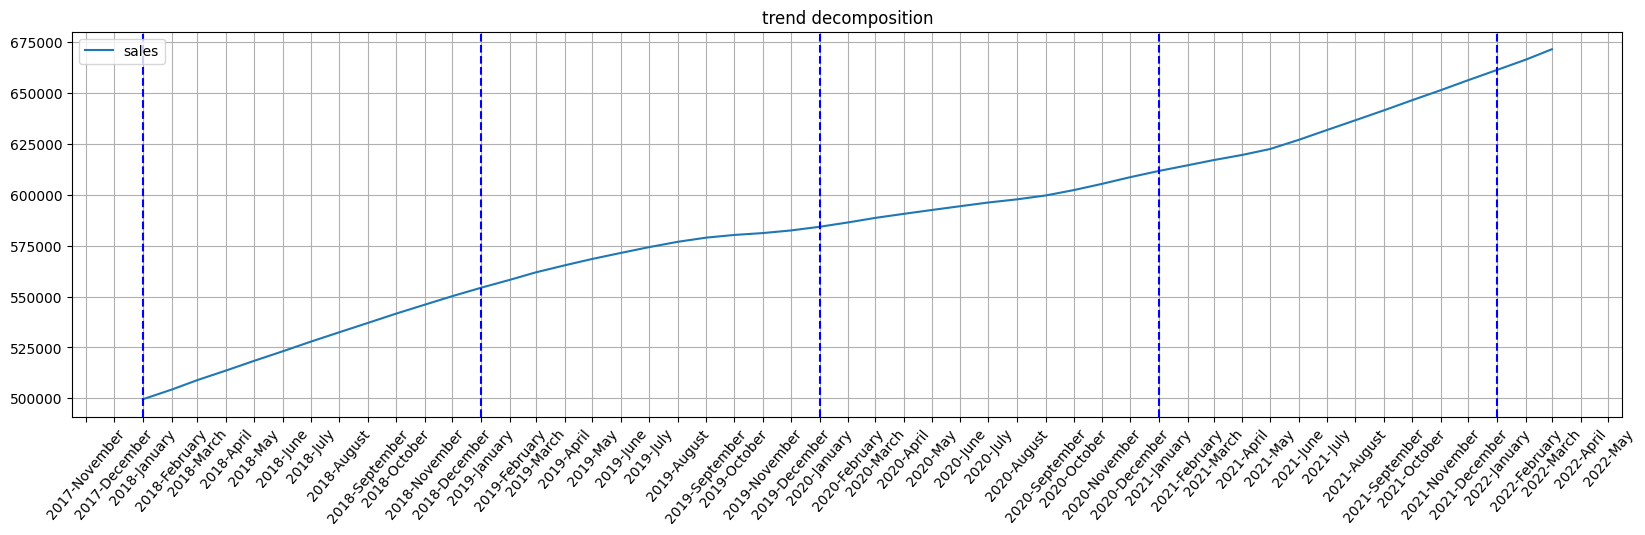

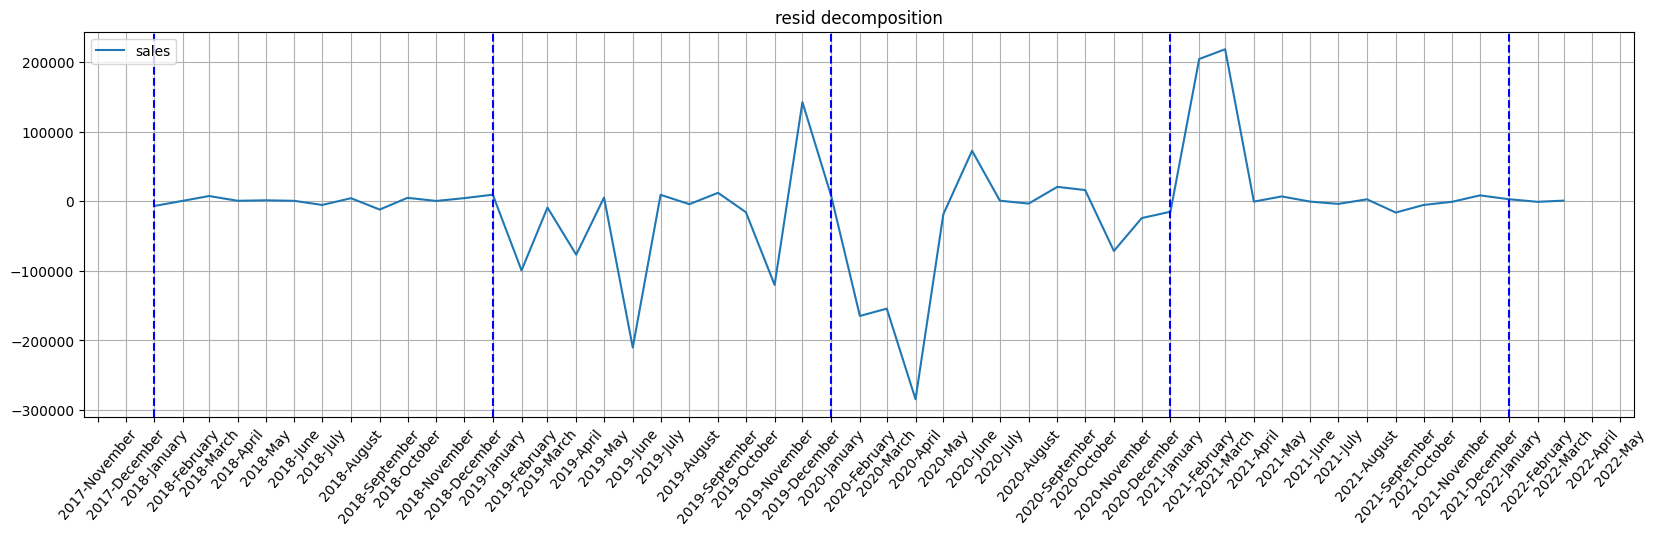

In [33]:
plot_decomposition(df_sal, show=["sales"])

**Seasonal Component**
- STL allows for dynamic changes in seasons thus the difference between months in different years
- Sales improving months: February, May, April, September, November
- Sales declining months: December-January (winter holidays), July-August (summer holidays)

**Trend Component**
- Clearly upwards trend in sales that seems to be accelerating in recent year

**Residual Component**
- Shows values that cannot be described just by seasonal and trend component 
- Clearly visible drop in January-March of 2020 which can be attributed to covid pandemic
- High sales in February-March of 2021 which can be attributed to special deal with new customer "KONZUM"

### 4.5. Market basket analysis

In [34]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [35]:
# Remove invalid items
df = df_sal.loc[
    (df_sal['NLS'] == False) &
    (~df_sal['price'].between(-1, 1, inclusive=True)) &
    (~df_sal['cost'].between(-1, 1, inclusive=True))
]
df = df.groupby(['sku']).sum().reset_index()
df = df.loc[
    (df['quantity'] > 10) &  # in total at least 10 items sold (minus returns)
    (df['price'] > 100),    # in total at least sold for 100 eur
    ['sku', 'quantity', 'price']
]
print('All unique items sold:', len(df_sal.groupby(['sku']).sum()))
print('Filtered unique items:', len(df))

All unique items sold: 15421
Filtered unique items: 4545


In [36]:
df_market = df_sal.loc[
    df_sal['sku'].isin(df['sku']) &
    df_sal['quantity'] > 0, 
    ['sku', 'invoice_no', 'quantity']
]

basket = df_market.groupby(['invoice_no', 'sku']).sum().unstack().reset_index().fillna(0).set_index('invoice_no')
basket = basket.applymap(lambda x: 0 if x <= 0 else 1)
basket.columns = basket.columns.droplevel()
frequent_itemsets = fpgrowth(basket.astype(bool), min_support=0.001, use_colnames=True)
df_ar = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [37]:
df_ar.sort_values(by=['confidence'], ascending=False).iloc[::2, :]

antecedents  consequents  antecedent support  \
234              (SXWTD-FT516, WW100K)  (FSMH1321J)            0.001680   
235           (SXWTD-FT516, FSMH1321J)     (WW100K)            0.001727   
134  (1-TRA209T, 1-TRA204T, 1-TRA208T)  (1-TRA206T)            0.001094   
128             (1-TRA209T, 1-TRA204T)  (1-TRA206T)            0.001220   
136  (1-TRA209T, 1-TRA208T, 1-TRA206T)  (1-TRA204T)            0.001204   
..                                 ...          ...                 ...   
32                            (KX1650)      (KW712)            0.016197   
222                         (DCD796P2)   (DCH133M1)            0.024248   
51                          (0-47-443)   (0-28-500)            0.016292   
47                          (DCD796P2)    (DWE4257)            0.024248   
152                           (BEG110)    (CS1250L)            0.025152   

     consequent support   support  confidence        lift  leverage  \
234            0.002171  0.001680    1.000000  460.562044  0.001676   
235            0.002219  0.001680    0.972477  438.288467  0.001676   
134            0.009382  0.001062    0.971014  103.493415  0.001052   
128            0.009382  0.001094    0.896104   95.509236  0.001082   
136            0.006197  0.001062    0.881579  142.263393  0.001054   
..                  ...       ...         ...         ...       ...   
32             0.016023  0.001157    0.071429    4.457892  0.000897   
222            0.010111  0.001664    0.068627    6.787126  0.001419   
51             0.008764  0.001030    0.063230    7.214460  0.000887   
47             0.014343  0.001490    0.061438    4.283478  0.001142   
152            0.009905  0.001268    0.050410    5.089109  0.001019   

     conviction  
234         inf  
235   36.252717  
134   34.176308  
128    9.534695  
136    8.392116  
..          ...  
32     1.059668  
222    1.062828  
51     1.058142  
47     1.050178  
152    1.042654  

[121 rows x 9 columns]

Association rules are necessary for understanding of market basket analysis and items frequently bought together which have important parallels with recommendation systems. Based on the results company can prepare better promotion strategies, cross-selling and adjust demand forecasting.  